## Q2) Build a transfer learnt model from a model trained on VGG by unfreezing some existing layers

##### 1)Data Preprocessig Scaling and Resizing ----> Done
##### 2)Image Augmentation:	Done
##### 3)Train and test data handled correctly----> Done
##### 4)Gaussian Blur, Histogram Equalization and Intensity thresholds:---->Done
##### 5)Model Trained 	Training Time:---->	Done
##### 6)AUC and Confusion Matrix Computed:---->Done
##### 7)Overfitting/Underfitting checked and handled	 first model overfit model   :----> done
##### 8)first round of  Empirical Tuning :- model overfit , :---->done
##### 9)second round : remove l2 regularization, optimizer learning rate increase,not use image thresholding, just one layes unfreeze:---->done

In [41]:
import os
import numpy as np
import cv2
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from sklearn.metrics import  accuracy_score, confusion_matrix, roc_curve, auc,classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import time 

In [2]:
### apply gaussion blur , Histogram Equalization, and image thresholding 
# remove thresholding as it dencrease accauracy.

In [3]:
# function for gausion an equalization 
def preprocess_image(image):

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    hsv_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = cv2.equalizeHist(hsv_image[:,:,2])
    equalized_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)


    return equalized_image

In [4]:
data_dir = "dataset/"
expression_labels = os.listdir(data_dir)
data_directories = []
for dire in os.listdir(data_dir):
    data_directories.append(os.path.join(data_dir, dire))

num_classes = len(expression_labels)

In [5]:
# image size
img_height, img_width = 128, 128

In [6]:
images = []
labels = []
for i, directory in enumerate(data_directories):
    class_images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_height, img_width))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        img = img / 255.0
#         img = preprocess_image(img)  
        img = img_to_array(img)
        class_images.append(img) 
        labels.append(i)
    images.extend(class_images)

In [7]:
# lists to numpy arrays img and labels 
images = np.array(images)
labels = np.array(labels)

In [8]:
# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42) 

In [9]:

# Print shapes to verify the split
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (12362, 128, 128, 3)
x_test shape: (3091, 128, 128, 3)
y_train shape: (12362,)
y_test shape: (3091,)


In [10]:
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

3    3233
4    3165
2    2939
1    1060
5    1000
0     965
dtype: int64

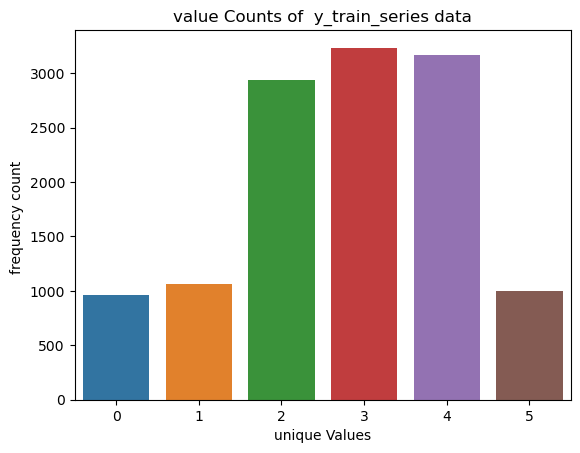

In [11]:
# plotting counts plot for train data 
sns.countplot(x=y_train_series)

# labels
plt.xlabel('unique Values')
plt.ylabel('frequency count ')
plt.title('value Counts of  y_train_series data')

plt.show()

In [12]:
# define data augmentation 
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

In [13]:
# select a image from the dataset
original_image = x_train[10]

# generate augmented images for the that  image
augmented_data_generator = train_datagen.flow(np.expand_dims(original_image, axis=0), batch_size=1)

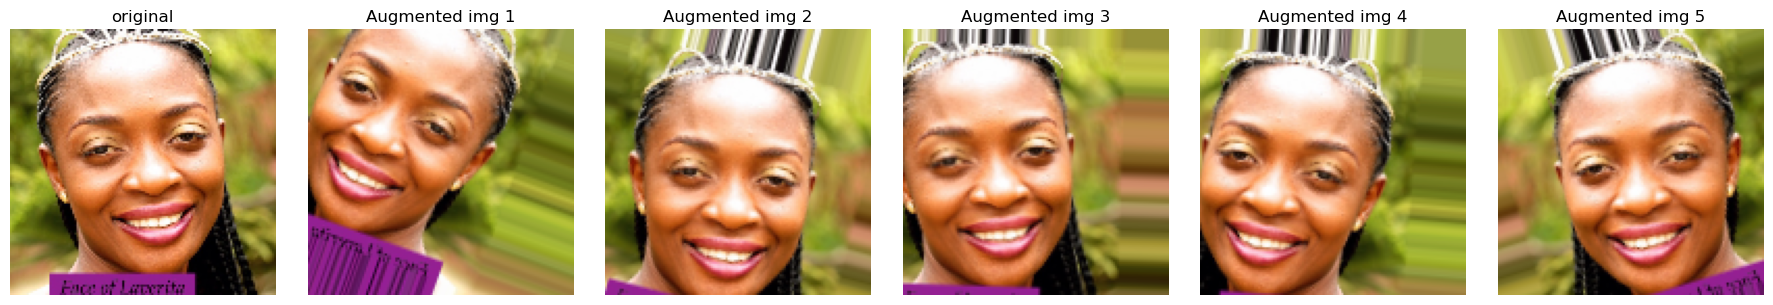

In [14]:
# plot original img and augmented imgs
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 3))

# plot original img
axes[0].imshow(original_image)
axes[0].set_title('original')
axes[0].axis('off')

# augmented images
for j in range(1, 6):
    augmented_image = next(augmented_data_generator)[0]
    axes[j].imshow(augmented_image)
    axes[j].set_title(f'Augmented img {j}')
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# unique labels and counts for calss
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# calculate class each weight
total_samples = len(y_train)
class_weights = total_samples / (len(unique_classes) * class_counts)

#  dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))


In [16]:
for class_label, weight in class_weights_dict.items():
    print("Class:", class_label, "Weight:", weight)

Class: 0 Weight: 2.135060449050086
Class: 1 Weight: 1.9437106918238993
Class: 2 Weight: 0.7010320970851763
Class: 3 Weight: 0.6372821940406227
Class: 4 Weight: 0.650974196945761
Class: 5 Weight: 2.0603333333333333


In [17]:
#  VGG-16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [18]:
# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
for layer in base_model.layers:
    layer.trainable = False

# unfreeze the last 2 layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

In [25]:
# define layers on top of the vgg model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(len(data_directories), activation='softmax', kernel_regularizer=l2(0.001)))

In [26]:
# compile the model
opt = Adam(learning_rate=0.02)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# starting the time
start_time = time.time()

In [28]:
history = model.fit(
    train_datagen.flow(x_train, y_train), batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10


387/387 [==============================] - 433s 1s/step - loss: 4.7500 - accuracy: 0.4526 - val_loss: 23.9687 - val_accuracy: 0.2591
Epoch 2/10
387/387 [==============================] - 430s 1s/step - loss: 8.9096 - accuracy: 0.4555 - val_loss: 12.6134 - val_accuracy: 0.1909
Epoch 3/10
387/387 [==============================] - 433s 1s/step - loss: 13.2398 - accuracy: 0.5006 - val_loss: 24.7731 - val_accuracy: 0.0776
Epoch 4/10
387/387 [==============================] - 435s 1s/step - loss: 26.6080 - accuracy: 0.5358 - val_loss: 25.8724 - val_accuracy: 0.4762
Epoch 5/10
387/387 [==============================] - 445s 1s/step - loss: 22.6500 - accuracy: 0.5575 - val_loss: 21.3532 - val_accuracy: 0.4662


In [29]:
# end the time
end_time = time.time()

In [30]:
#  calculate the model training time 
training_time = end_time - start_time
print("model training time:", training_time, "seconds")

model training time: 2177.9805800914764 seconds


In [31]:
# evaluate model on test data 
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy:", accuracy)

97/97 [==============================] - 59s 604ms/step
Test Accuracy: 0.19087673891944354


In [32]:
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.95      0.65       240
           1       0.10      0.97      0.18       253
           2       0.00      0.00      0.00       801
           3       0.58      0.15      0.24       794
           4       0.00      0.00      0.00       769
           5       0.00      0.00      0.00       234

    accuracy                           0.19      3091
   macro avg       0.20      0.34      0.18      3091
weighted avg       0.20      0.19      0.13      3091



C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# plot roc curve and area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(data_directories)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

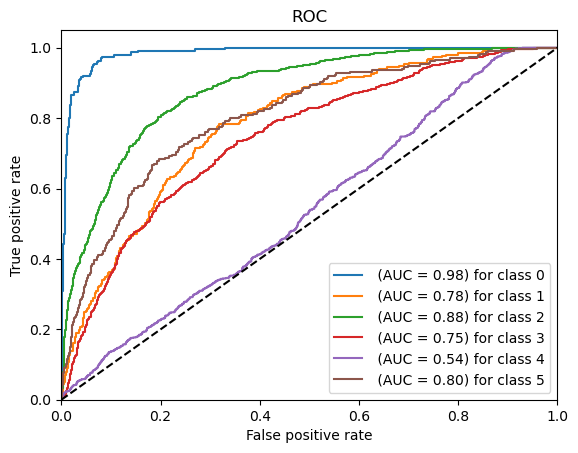

In [34]:
# Plot ROC curve
plt.figure()
for i in range(len(data_directories)):
    plt.plot(fpr[i], tpr[i], label=f' (AUC = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [35]:
# extract class names from the path
class_names = [os.path.basename(directory) for directory in data_directories]

In [36]:
# confusion matrix
con_mtrx = confusion_matrix(y_test, y_pred_classes)

print("Confusion Matrix:")
print(con_mtrx)


Confusion Matrix:
[[227  13   0   0   0   0]
 [  7 246   0   0   0   0]
 [ 15 766   0  20   0   0]
 [ 74 603   0 117   0   0]
 [ 21 687   0  61   0   0]
 [111 120   0   3   0   0]]


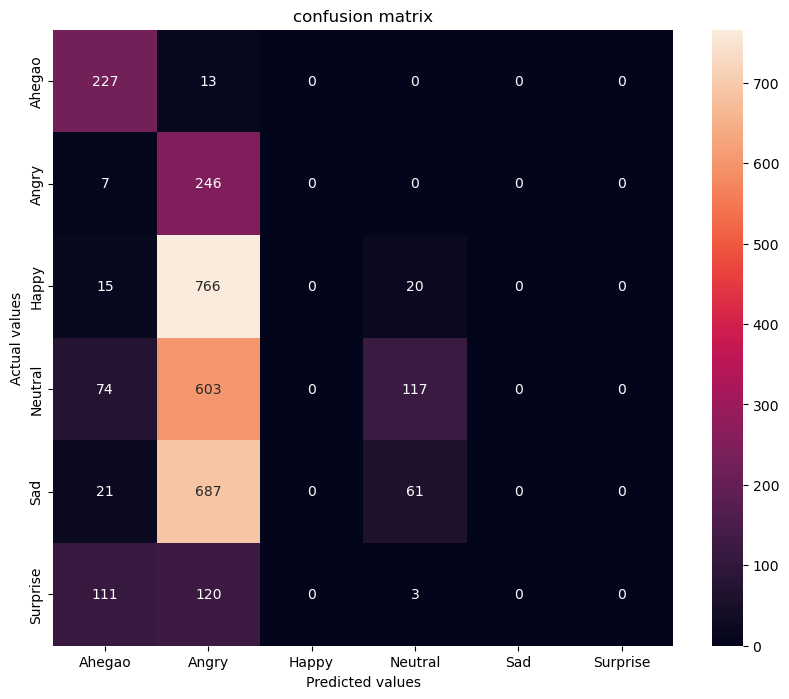

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(con_mtrx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('confusion matrix')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


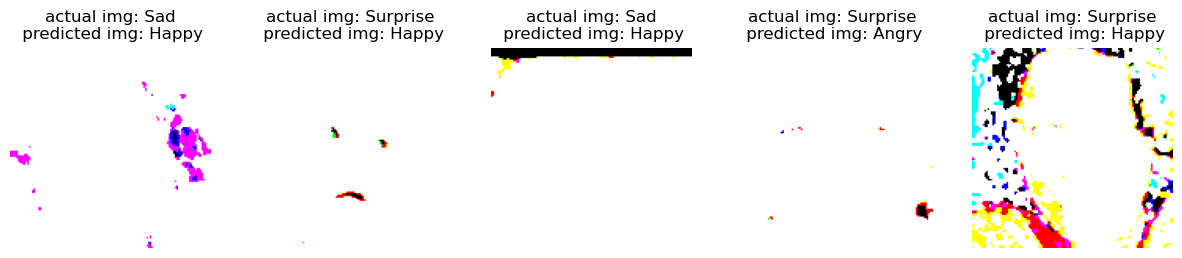

In [38]:
# img samples from the test img
sample_img = 5  
random_indices = random.sample(range(len(x_test)), sample_img)
expression_folders = ["Angry", "Happy", "Neutral", "Sad", "Surprise"]
# model predictions on the semples
pred_labels = model.predict(x_test[random_indices])
pred_classes = np.argmax(pred_labels, axis=1)

# images with actual and predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, sample_img, i+1)
    plt.imshow(x_test[idx], cmap='gray')
    actual_label = expression_folders[y_test[idx]]
    pred_label = expression_folders[pred_classes[i]]
    plt.title(f'actual img: {actual_label}\n predicted img: {pred_label}')
    plt.axis('off')
plt.show()

In [19]:
for layer in base_model.layers:
    layer.trainable = False

# unfreeze the last 2 layers
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [20]:
# define layers on top of the vgg model
model1 = Sequential()
model1.add(base_model)
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))  # , kernel_regularizer=l2(0.002))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))
model1.add(Dense(len(data_directories), activation='softmax')) # , kernel_regularizer=l2(0.002)

In [21]:
# compile the model
opt = Adam(learning_rate=0.03)
model1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# starting the time
start_time = time.time()

In [23]:
history = model1.fit(
    train_datagen.flow(x_train, y_train), batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10


387/387 [==============================] - 455s 1s/step - loss: 1.3544 - accuracy: 0.4523 - val_loss: 6.2569 - val_accuracy: 0.2491
Epoch 2/10
387/387 [==============================] - 494s 1s/step - loss: 1.0585 - accuracy: 0.5731 - val_loss: 3.0153 - val_accuracy: 0.3368
Epoch 3/10
387/387 [==============================] - 465s 1s/step - loss: 0.9542 - accuracy: 0.6233 - val_loss: 1.1318 - val_accuracy: 0.5946
Epoch 4/10
387/387 [==============================] - 447s 1s/step - loss: 0.8802 - accuracy: 0.6626 - val_loss: 1.2054 - val_accuracy: 0.6105
Epoch 5/10
387/387 [==============================] - 439s 1s/step - loss: 0.8261 - accuracy: 0.6776 - val_loss: 2.0183 - val_accuracy: 0.5988
Epoch 6/10
387/387 [==============================] - 440s 1s/step - loss: 0.7994 - accuracy: 0.6886 - val_loss: 0.8168 - val_accuracy: 0.6985
Epoch 7/10
387/387 [==============================] - 444s 1s/step - loss: 0.7660 - accuracy: 0.7047 - val_loss: 1.7838 - val_accuracy: 0.72

In [24]:
# end the time
end_time = time.time()

In [25]:
#  calculate the model training time 
training_time = end_time - start_time
print("model training time:", training_time, "seconds")

model training time: 4122.957351922989 seconds


In [26]:
# evaluate model on test data 
y_pred1 = model1.predict(x_test)
y_pred_classes1 = np.argmax(y_pred1, axis=1)
accuracy1 = accuracy_score(y_test, y_pred_classes1)
print("Test Accuracy:", accuracy1)

97/97 [==============================] - 81s 835ms/step
Test Accuracy: 0.698479456486574


In [27]:
report = classification_report(y_test, y_pred_classes1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       240
           1       0.51      0.72      0.59       253
           2       0.80      0.92      0.86       801
           3       0.59      0.84      0.70       794
           4       0.86      0.30      0.44       769
           5       0.89      0.47      0.61       234

    accuracy                           0.70      3091
   macro avg       0.74      0.70      0.68      3091
weighted avg       0.74      0.70      0.67      3091



In [28]:
# plot roc curve and area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(data_directories)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

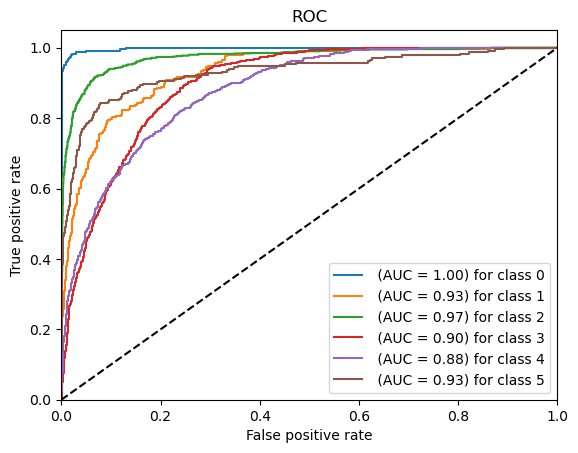

In [29]:
# Plot ROC curve
plt.figure()
for i in range(len(data_directories)):
    plt.plot(fpr[i], tpr[i], label=f' (AUC = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [30]:
# confusion matrix
con_mtrx = confusion_matrix(y_test, y_pred_classes1)

print("Confusion Matrix:")
print(con_mtrx)


Confusion Matrix:
[[235   0   3   2   0   0]
 [  4 181  12  45   8   3]
 [  5  14 737  39   5   1]
 [ 14  35  44 670  25   6]
 [  7 113  83 335 227   4]
 [ 29  15  39  42   0 109]]


In [32]:
# extract class names from the path
class_names = [os.path.basename(directory) for directory in data_directories]

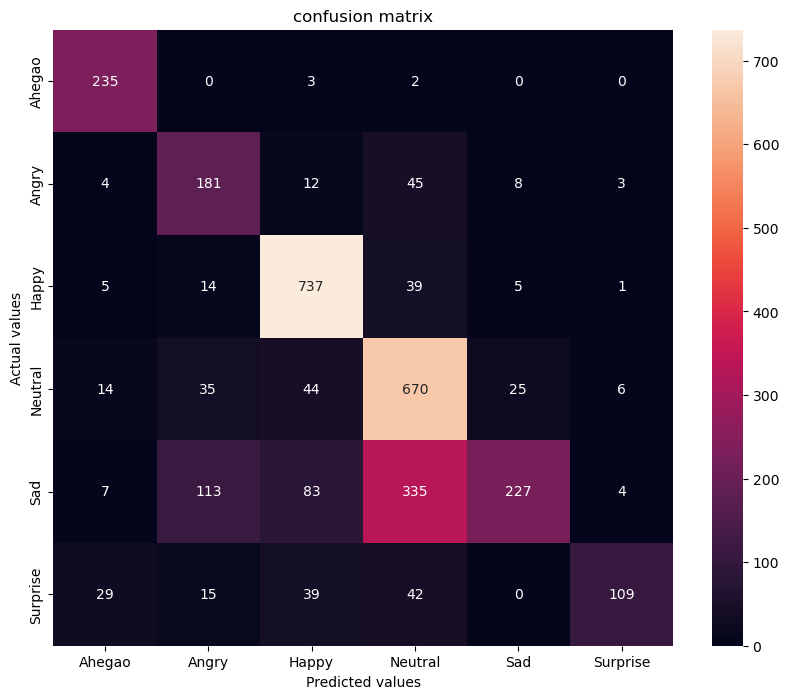

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(con_mtrx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('confusion matrix')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

1/1 [==============================] - 0s 360ms/step


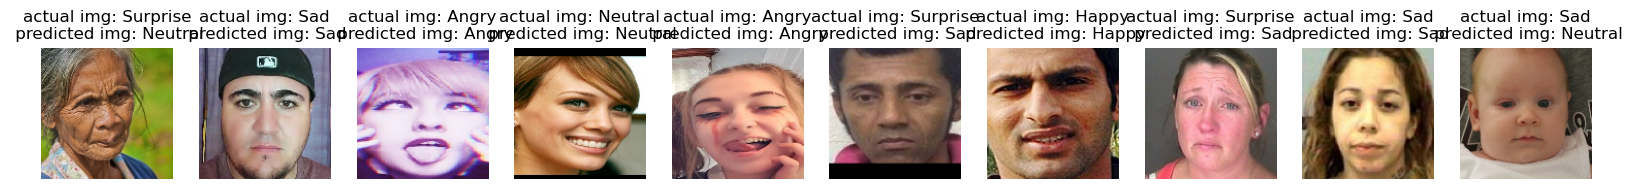

In [34]:
# img samples from the test img
sample_img = 10  
random_indices = random.sample(range(len(x_test)), sample_img)
expression_folders = ["Angry", "Happy", "Neutral", "Sad", "Surprise"]
# model predictions on the semples
pred_labels1 = model1.predict(x_test[random_indices])
pred_classes1 = np.argmax(pred_labels1, axis=1)

# images with actual and predicted labels
plt.figure(figsize=(20, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(1, sample_img, i+1)
    plt.imshow(x_test[idx], cmap='gray')
    actual_label = expression_folders[y_test[idx]]
    pred_label1 = expression_folders[pred_classes1[i]]
    plt.title(f'actual img: {actual_label}\n predicted img: {pred_label1}')
    plt.axis('off')
plt.show()

In [ ]:
#### looks mess print in 2 rows 

1/1 [==============================] - 0s 343ms/step


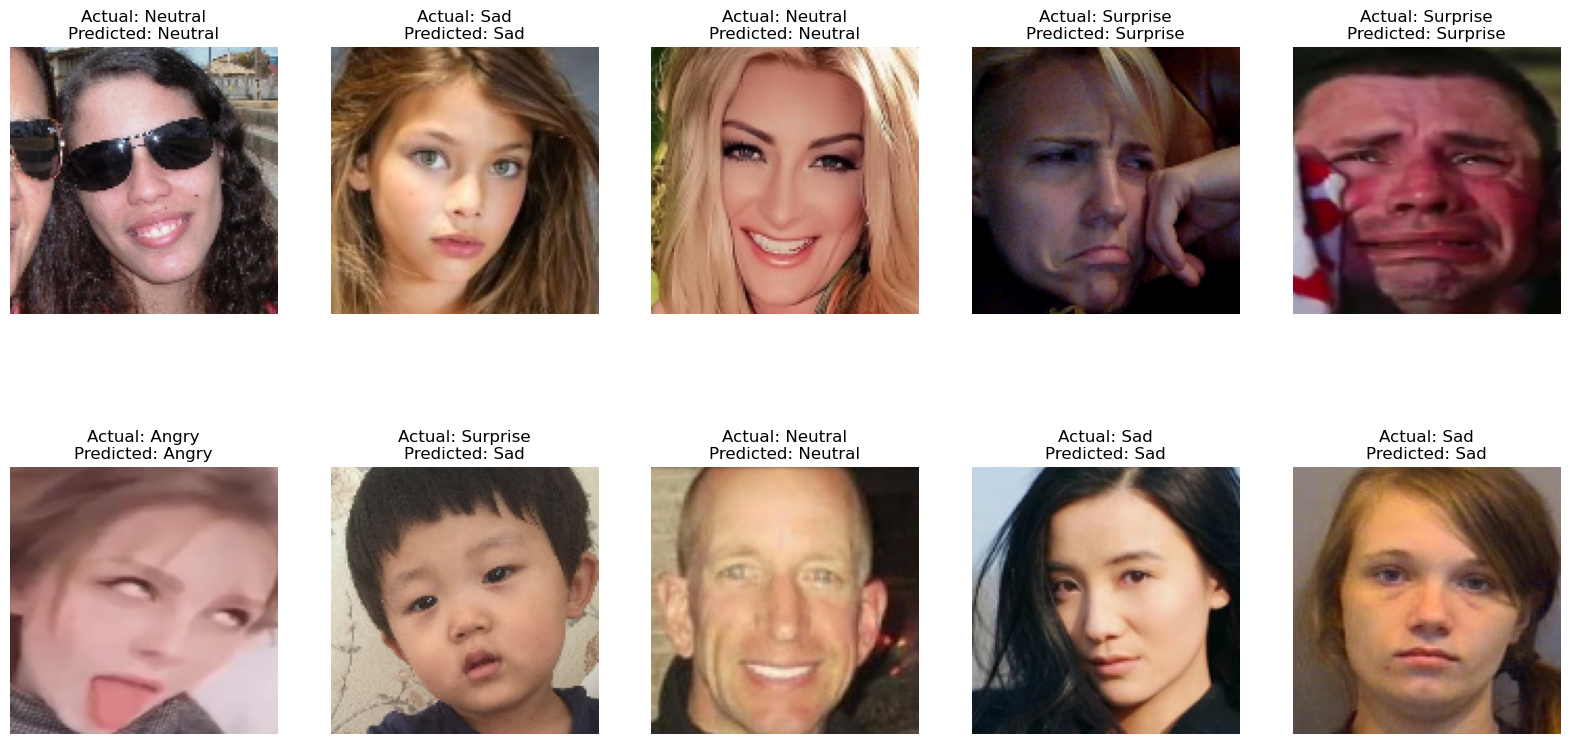

In [35]:
import random

# img samples from the test img
sample_img = 10  
random_indices = random.sample(range(len(x_test)), sample_img)
expression_folders = ["Angry", "Happy", "Neutral", "Sad", "Surprise","Ahegao"]
# model predictions on the semples
pred_labels1 = model1.predict(x_test[random_indices])
pred_classes1 = np.argmax(pred_labels1, axis=1)

# images with actual and predicted labels
plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    if i < 5:
        plt.subplot(2, 5, i+1)
    else:
        plt.subplot(2, 5, i+1-5+5)  # adjusting the index for the second row
    plt.imshow(x_test[idx], cmap='gray')
    actual_label = expression_folders[y_test[idx]]
    pred_label1 = expression_folders[pred_classes1[i]]
    plt.title(f'Actual: {actual_label}\nPredicted: {pred_label1}')
    plt.axis('off')
plt.show()


In [38]:
model1.save('VGGUnfreeze.keras')

In [42]:
model = tf.keras.models.load_model('VGGUnfreeze.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                        

In [43]:
print(tf.__version__)

2.15.0
